# Data Cleaning - full data set

In [7]:
%run setup.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
14.089097293304098


In [8]:
# import modin.pandas as pd

In [9]:
from utils import get_station_data, merge_values_counts

# Load

In [10]:
# city boundaries of washington
washington_boundary = gpd.read_file(config['raw_data_paths']['washington_outline'])
# washington_boundary = gpd.read_file('../data/raw/01_saopaulo_hdi.geojson')
washington_boundary = washington_boundary.drop(columns=['AREAMILES', 'OBJECTID', 'STATE_CITY', 'CAPITAL', 'WEB_URL', 'GLOBALID', 'CREATOR', 'CREATED', 'EDITOR','EDITED', 'SHAPEAREA', 'SHAPELEN'])
washington_boundary.head()

,CITY_NAME,AREAKM,GIS_ID,geometry
0,Washington,177.47,DCBndyPly_1,"POLYGON ((-77.1198 38.93435, -77.11979 38.9343..."


In [11]:
# initialized rides data 
df = pd.read_parquet(config['processed_data_paths']['rides_init'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10677232 entries, 0 to 10693996
Data columns (total 12 columns):
 #   Column              Dtype          
---  ------              -----          
 0   rideable_type       category       
 1   started_at          datetime64[ms] 
 2   ended_at            datetime64[ms] 
 3   start_station_name  category       
 4   start_station_id    uint32[pyarrow]
 5   end_station_name    category       
 6   end_station_id      uint32[pyarrow]
 7   start_lat           float[pyarrow] 
 8   start_lng           float[pyarrow] 
 9   end_lat             float[pyarrow] 
 10  end_lng             float[pyarrow] 
 11  member_casual       category       
dtypes: category(4), datetime64[ms](2), float[pyarrow](4), uint32[pyarrow](2)
memory usage: 557.6 MB


# Features
- is_within_city: ride is within the city boundaries, i.e. Start and End are both within the boundaries
- is_holiday: Day of ride is a holiday
- ride_duration: ride duration in s

## Ride within boundaries of city center
- Are the rides within the city center service area? The activities outside might not be that interesting
- Problem: no map of the full service boundaries is available!

In [12]:
# NOTE gpd thinks in longitude and latitude, not the other way around
def check_if_ride_within_city_boundaries(df, city_boundary) -> pd.Series:
    geometry = [LineString([(lng1, lat1), (lng2, lat2)]) for lat1, lng1, lat2, lng2 in zip(df.start_lat, df.start_lng, df.end_lat, df.end_lng)]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    rides_with_city_info = gpd.sjoin(gdf, city_boundary, how="left", predicate="intersects", lsuffix='point', rsuffix='city')
    return rides_with_city_info.index_city.notna()

def check_if_start_within_city_boundaries(df, city_boundary) -> pd.Series:
    geometry = [Point((lng1, lat1)) for lat1, lng1 in zip(df.start_lat, df.start_lng)]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    rides_with_city_info = gpd.sjoin(gdf, city_boundary, how="left", predicate="within", lsuffix='point', rsuffix='city')
    return rides_with_city_info.index_city.notna()

def check_if_end_within_city_boundaries(df, city_boundary) -> pd.Series:
    geometry = [Point(lng2, lat2) for lat2, lng2 in zip(df.end_lat, df.end_lng)]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    rides_with_city_info = gpd.sjoin(gdf, city_boundary, how="left", predicate="within", lsuffix='point', rsuffix='city')
    return rides_with_city_info.index_city.notna()

df['start_is_within_city']  = check_if_start_within_city_boundaries(df[['start_lat', 'start_lng', 'end_lat', 'end_lng']], washington_boundary)
df['end_is_within_city']    = check_if_end_within_city_boundaries(df[['start_lat', 'start_lng', 'end_lat', 'end_lng']], washington_boundary)
df['ride_is_within_city']   = df['start_is_within_city'] & df['end_is_within_city']

In [13]:
df.head()

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_is_within_city,end_is_within_city,ride_is_within_city
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015,38.88044,-77.025238,38.8946,-77.072304,member,True,False,False
1,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,31111,NaN,<NA>,38.917191,-77.025887,38.959999,-77.019997,casual,True,True,True
2,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214,14th & Belmont St NW,31119,38.91214,-77.038567,38.920872,-77.031693,member,True,True,True
3,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926,Wilson Blvd. & N. Vermont St.,31926,38.879478,-77.114563,38.879478,-77.114563,member,False,False,False
4,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,31651,14th & Newton St NW,31649,38.93132,-77.028252,38.931992,-77.032959,member,True,True,True


In [17]:
# TODO why this here? why is a new index created? 
# It does not matter, so the new index can be taken
if 'index' in df.columns: #hasattr(df, 'index'):
    df = df.drop(columns='index')

In [18]:
# TODO move to other ipynb
mask_2023 = df.started_at.dt.year >= 2023

print('rides that start outside the city limits: ', sum(~df.loc[mask_2023, 'start_is_within_city']) / df[mask_2023].shape[0])
print('rides that end outside the city limits: ',   sum(~df.loc[mask_2023, 'end_is_within_city']) / df[mask_2023].shape[0])

rides that start outside the city limits:  0.12037237730222583
rides that end outside the city limits:  0.11877287544305148


In [19]:
# TODO plot the rides that are outside the city boundaries

## Holiday

In [20]:
df['is_holiday'] = df.started_at.dt.date.apply(lambda x: x in US_HOLIDAYS.date)

In [21]:
mask_4thjuly = df.started_at.dt.date == datetime.date(2023, 7, 4)
df[mask_4thjuly]

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_is_within_city,end_is_within_city,ride_is_within_city,is_holiday
8221170,classic_bike,2023-07-04 00:00:03,2023-07-04 00:03:51,5th & K St NW,31600,North Capitol & K St NE,31675,38.903042,-77.019028,38.902439,-77.008247,member,True,True,True,True
8221171,classic_bike,2023-07-04 00:00:42,2023-07-04 00:11:23,New Jersey Ave & R St NW,31509,3rd & H St NE,31616,38.912659,-77.01767,38.90041,-77.001953,casual,True,True,True,True
8221172,classic_bike,2023-07-04 00:01:20,2023-07-04 00:22:46,1st & N St SE,31209,8th & H St NW,31228,38.875019,-77.005753,38.8997,-77.023087,casual,True,True,True,True
8221173,classic_bike,2023-07-04 00:01:26,2023-07-04 00:19:40,37th & O St NW / Georgetown University,31236,18th & R St NW,31278,38.907841,-77.071663,38.912651,-77.041832,member,True,True,True,True
8221174,classic_bike,2023-07-04 00:01:38,2023-07-04 00:12:19,23rd & M St NW,31128,Thomas Circle,31241,38.9053,-77.050262,38.905899,-77.032501,member,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8241095,classic_bike,2023-07-04 23:59:14,2023-07-05 00:13:12,6th St & Indiana Ave NW,31264,1st & K St NE,31662,38.894569,-77.019943,38.90239,-77.005653,member,True,True,True,True
8241096,classic_bike,2023-07-04 23:59:32,2023-07-05 00:08:13,North Capitol St & F St NW,31624,5th St & Massachusetts Ave NW,31265,38.897449,-77.009888,38.900928,-77.018677,casual,True,True,True,True
8241097,classic_bike,2023-07-04 23:59:38,2023-07-05 00:11:35,New Jersey Ave & K St NW,31642,5th & Morse St NE,31536,38.902569,-77.013672,38.907291,-76.999168,casual,True,True,True,True
8241098,electric_bike,2023-07-04 23:59:54,2023-07-05 00:02:29,14th & Belmont St NW,31119,14th & Irving St NW,31124,38.921139,-77.031837,38.928551,-77.032219,member,True,True,True,True


## Ride Duration

In [22]:
df['ride_duration'] = df.ended_at - df.started_at
df['ride_duration'] = df['ride_duration'].apply(lambda x: x.seconds)

# Cleaning
- separate redundant information and create separate tables
  - station table: station_id, lat, lng (lat, log as mean values), start, end
- transform data
  - rideable_type -> 0,1,2,... OR classic: True, False
  - member_casual -> 0,1,2,...
- data integrity
  - lat, lng in Washington bbox
  - if start / end - lat / lng == null, then remove
- reduce data type to reasonable precision

## Ride duration

Only keep rides that lasted longer than 30s.

In [23]:
rides_too_short_to_be_true = df.ride_duration < 30

In [24]:
rides_too_short_to_be_true.sum() / df.shape[0]

np.float64(0.009685656357378017)

In [25]:
df = df[~rides_too_short_to_be_true]

## Latitude and Longitude

Check if cooordinates in bounding box

In [ ]:
# service area bbox
min_lng, min_lat = -77.454987, 38.701588
max_lng, max_lat = -76.784821, 39.168400
service_area_bbox = (min_lng, min_lat, max_lng, max_lat)

In [29]:
mask_lat_lng_outside_bbox = ((df.start_lng < min_lng) | (df.start_lng > max_lng) | (df.end_lng < min_lng) | (df.end_lng > max_lng) |
(df.start_lat < min_lat) | (df.start_lat > max_lat) | (df.end_lat < min_lat) | (df.end_lat > max_lat))

mask_lat_lng_outside_bbox.sum()

26

In [30]:
df = df[~mask_lat_lng_outside_bbox]

## Stations

Clean station data such that theres only one lat, lng per station, in order to **???**
- simplify the data: Replace the bike location with station location if bike is returned at a station

1. Get all station data from rides table
2. Build station table
3. Clean main data set with station table

Questions
- Are stations moved?

Problems:
- stations have many locations that vary strongly
  - Can the station locations be determined by the available data set?
- station_id, station_name have more unique values than station_id
  - What does that mean?
- Are stations moved? What happens in the data set?
- Errors in the bike location up to 10m

Assumptions
- a station's location is determined by where most of the bikes are put.
- all ride data associated with 

Steps in order to build station table
1. clean station names
2. set precision for lat and long
3. remove station coordinate outliers
4. calculate averages of location coordinates

### Clean Station Names

In [125]:
# clean station names
# TODO is there a way to make it more efficient? 
df.start_station_name = df.start_station_name.str.strip()
df.end_station_name = df.end_station_name.str.strip()

### Some overall stuff

In [126]:
mask_start = ~df.start_station_id.isna()
mask_end = ~df.end_station_id.isna()

### Use docked bikes

In [127]:
mask_docked_bikes = df.rideable_type=='docked_bike'

stations_docked_bikes = [None, None]
stations_docked_bikes[0] = get_station_data(df, mask_docked_bikes & mask_start, ['ended_at', 'start_station_name', 'start_station_id', 'start_lat', 'start_lng'], NDEC_LAT_LNG, False)
stations_docked_bikes[1] = get_station_data(df, mask_docked_bikes & mask_end, ['ended_at', 'end_station_name', 'end_station_id', 'end_lat', 'end_lng'], NDEC_LAT_LNG, False)

stations_docked_bikes = pd.concat(stations_docked_bikes, axis=0)

stations_docked_bikes = stations_docked_bikes.groupby(['station_name', 'station_id']).agg({
    'lat' : ['median', 'mean', 'std', 'count'],
    'lng' : ['median', 'mean', 'std', 'count'],
    'date': ['min', 'max']
    })

stations_docked_bikes.columns = ['_'.join(col) for col in stations_docked_bikes.columns]
stations_docked_bikes = stations_docked_bikes.reset_index()
stations_docked_bikes

,station_name,station_id,lat_median,lat_mean,lat_std,lat_count,lng_median,lng_mean,lng_std,lng_count,date_min,date_max
0,10th & E St NW,31256,38.895908,38.895908,0.0,7256,-77.026062,-77.026062,0.0,7256,2021-01-02,2023-09-12
1,10th & Florida Ave NW,31120,38.920391,38.920391,0.0,428,-77.025681,-77.025681,0.0,428,2021-01-06,2022-08-16
2,10th & G St NW,31274,38.898239,38.898239,0.0,3317,-77.026237,-77.026237,0.0,3317,2021-01-02,2023-09-11
3,10th & H St NE,31672,38.899979,38.899979,0.0,550,-76.992722,-76.992722,0.0,550,2021-12-12,2023-09-07
4,10th & K St NW,31263,38.902401,38.902401,0.0,5769,-77.026222,-77.026222,0.0,5769,2021-01-01,2023-09-11
...,...,...,...,...,...,...,...,...,...,...,...,...
811,Wisconsin Ave & Rodman St NW,31333,38.939671,38.939671,0.0,128,-77.075279,-77.075279,0.0,128,2022-08-24,2023-09-04
812,Woodglen Dr & Executive Blvd,32078,39.043171,39.043171,0.0,413,-77.113503,-77.113503,0.0,413,2021-01-10,2023-09-12
813,Woodley Park Metro / Calvert St & Connecticut ...,31323,38.923389,38.923389,0.0,3041,-77.051819,-77.051819,0.0,3041,2021-01-02,2023-09-12
814,Woodmont Ave & Strathmore St,32055,38.979881,38.979881,0.0,872,-77.093521,-77.093513,0.0,872,2021-01-02,2023-09-12


In [128]:
stations_serviced = pd.concat(
    [df[['ended_at', 'start_station_id', 'start_station_name']].rename(columns=lambda x: x.replace('start_','')), 
     df[['ended_at', 'end_station_id', 'end_station_name']].rename(columns=lambda x: x.replace('end_',''))],
    axis=0
    )
stations_serviced.ended_at = stations_serviced.ended_at.dt.date
stations_serviced = stations_serviced.groupby(['station_id', 'station_name']).agg({'ended_at':['min', 'max']})
stations_serviced.columns = ['_'.join(col) for col in stations_serviced.columns]
stations_serviced = stations_serviced.reset_index()
stations_serviced

,station_id,station_name,ended_at_min,ended_at_max
0,30200,9th St & Pennsylvania Ave NW,2023-02-01,2023-12-31
1,30201,9th & G St NW,2023-02-02,2023-12-31
2,31000,Eads St & 15th St S,2021-01-01,2023-12-31
3,31001,18th St & S Eads St,2021-01-01,2021-08-25
4,31002,Crystal Dr & 20th St S,2021-01-01,2023-12-31
...,...,...,...,...
862,32900,Motivate BX Tech office,2023-04-07,2023-04-07
863,32901,6035 Warehouse,2021-01-08,2023-12-25
864,32906,V1 Warehouse Test Station,2022-03-03,2022-03-03
865,32909,tech trailer V-1,2023-10-19,2023-10-19


In [129]:
check_stations_services = pd.merge(stations_docked_bikes, stations_serviced, on=['station_id', 'station_name'], how='left')
check_stations_services['check'] = check_stations_services.date_max - check_stations_services.ended_at_max
check_stations_services

,station_name,station_id,lat_median,lat_mean,lat_std,lat_count,lng_median,lng_mean,lng_std,lng_count,date_min,date_max,ended_at_min,ended_at_max,check
0,10th & E St NW,31256,38.895908,38.895908,0.0,7256,-77.026062,-77.026062,0.0,7256,2021-01-02,2023-09-12,2021-01-01,2023-12-31,"-110 days, 0:00:00"
1,10th & Florida Ave NW,31120,38.920391,38.920391,0.0,428,-77.025681,-77.025681,0.0,428,2021-01-06,2022-08-16,2021-01-01,2022-08-18,"-2 days, 0:00:00"
2,10th & G St NW,31274,38.898239,38.898239,0.0,3317,-77.026237,-77.026237,0.0,3317,2021-01-02,2023-09-11,2021-01-01,2024-01-01,"-112 days, 0:00:00"
3,10th & H St NE,31672,38.899979,38.899979,0.0,550,-76.992722,-76.992722,0.0,550,2021-12-12,2023-09-07,2021-11-30,2023-12-31,"-115 days, 0:00:00"
4,10th & K St NW,31263,38.902401,38.902401,0.0,5769,-77.026222,-77.026222,0.0,5769,2021-01-01,2023-09-11,2021-01-01,2023-12-31,"-111 days, 0:00:00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,Wisconsin Ave & Rodman St NW,31333,38.939671,38.939671,0.0,128,-77.075279,-77.075279,0.0,128,2022-08-24,2023-09-04,2022-08-10,2023-12-31,"-118 days, 0:00:00"
812,Woodglen Dr & Executive Blvd,32078,39.043171,39.043171,0.0,413,-77.113503,-77.113503,0.0,413,2021-01-10,2023-09-12,2021-01-01,2023-12-31,"-110 days, 0:00:00"
813,Woodley Park Metro / Calvert St & Connecticut ...,31323,38.923389,38.923389,0.0,3041,-77.051819,-77.051819,0.0,3041,2021-01-02,2023-09-12,2021-01-01,2023-12-31,"-110 days, 0:00:00"
814,Woodmont Ave & Strathmore St,32055,38.979881,38.979881,0.0,872,-77.093521,-77.093513,0.0,872,2021-01-02,2023-09-12,2021-01-01,2023-12-31,"-110 days, 0:00:00"


In [130]:
# get station where data is too old to be true
redo_stations = check_stations_services.loc[check_stations_services.check < pd.Timedelta(days=-120), ['station_id', 'station_name']]
redo_stations

,station_id,station_name
11,31535,10th St & Rhode Island Ave NE
25,31511,12th & Irving St NE
29,31542,12th & Varnum St NE
31,31644,12th St & Pennsylvania Ave SE
38,32006,13th St & Eastern Ave
...,...,...
789,32087,White Oak Rec Center
790,32093,White Oak Transit Center
792,31942,Whiting & Lane Dr
798,31902,Wilson Blvd & N Illinois St


- locations are good
- not all stations are included!

In [131]:
# TODO move downwards : stations_names_ids not yet defined!
stations_names_ids = pd.concat([
    df[['start_station_id', 'start_station_name']].rename(columns=lambda x: x.replace('start_','')),
    df[['end_station_id', 'end_station_name']].rename(columns=lambda x: x.replace('end_',''))
    ], axis=0).drop_duplicates()
stations_names_ids = stations_names_ids[stations_names_ids.station_id.notna() & stations_names_ids.station_name.notna()]

In [132]:
missing_stations = pd.merge(stations_names_ids, stations_docked_bikes, on=['station_id', 'station_name'], how='outer')
missing_stations = missing_stations[missing_stations.lat_mean.isna() | missing_stations.lng_mean.isna()]
missing_stations

,station_id,station_name,lat_median,lat_mean,lat_std,lat_count,lng_median,lng_mean,lng_std,lng_count,date_min,date_max
60,31051,12th St N & N Pierce St,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
120,31096,Columbia Pike & S Highland St,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
192,31220,21st NW & E St NW,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
310,31331,Arizona & McArthur NW,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
316,31385,Old Meadow Rd & Old Meadow Ln,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
317,31386,Prosperity Ave & Avenir Pl,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
318,31387,Kingsbridge Dr & Draper Dr,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
319,31389,Route 29 & Circle Woods Dr,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
321,31391,44th St & New Mexico Ave NW,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
322,31392,39th St & Tunlaw Rd NW,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN


In [133]:
missing_stations[missing_stations.duplicated(subset=['station_id', 'station_name'], keep=False)]

,station_id,station_name,lat_median,lat_mean,lat_std,lat_count,lng_median,lng_mean,lng_std,lng_count,date_min,date_max


### Get station data

In [134]:
# get all station data
start_stations = get_station_data(df, mask_start, ['ended_at', 'start_station_name', 'start_station_id', 'start_lat', 'start_lng'], dec=NDEC_LAT_LNG, drop_dups=False)
end_stations = get_station_data(df, mask_end, ['ended_at', 'end_station_name','end_station_id', 'end_lat', 'end_lng'], dec=NDEC_LAT_LNG, drop_dups=False)
stations = pd.concat(
    [start_stations, end_stations],
    axis = 0
    )

# group by 
stations = stations.groupby(['station_name', 'station_id', 'lat', 'lng']).agg({'date':['count', 'min', 'max']})
stations.columns = ['_'.join(col) for col in stations.columns]
stations.rename(columns={'date_count':'count'})
stations = stations.reset_index()

stations.head()

,station_name,station_id,lat,lng,date_count,date_min,date_max
0,10th & E St NW,31256,38.89529,-77.026161,1,2023-11-29,2023-11-29
1,10th & E St NW,31256,38.895378,-77.025841,1,2021-05-02,2021-05-02
2,10th & E St NW,31256,38.89542,-77.02562,1,2021-05-07,2021-05-07
3,10th & E St NW,31256,38.895481,-77.025757,1,2021-09-20,2021-09-20
4,10th & E St NW,31256,38.89555,-77.026161,1,2021-11-28,2021-11-28


In [135]:
# restrict to missing station data
mask_missing_stations = (
    (stations.station_id.isin(missing_stations.station_id) & stations.station_name.isin(missing_stations.station_name)) |
    (stations.station_id.isin(redo_stations.station_id) & stations.station_name.isin(redo_stations.station_name))
    )
print(mask_missing_stations.sum())
stations_calc = stations[mask_missing_stations]

39189


In [136]:
stations_calc.nunique()

station_name     261
station_id       257
lat             5418
lng             5202
date_count       331
date_min        1094
date_max        1089
dtype: int64

In [137]:
# plot sample on map
n_ids = 10
n_stations_per_id = 1000

# ids = station_ids.sample(n_ids)
ids = list(stations.station_id.value_counts().sort_values(ascending=False).head(n_ids).index)

stations_samples = []
for i in ids:
    stations_sample = stations[stations.station_id == i]
    if stations_sample.shape[0] > n_stations_per_id:
        stations_sample = stations_sample.sample(n_stations_per_id)
    stations_samples.append(stations_sample)
stations_samples = pd.concat(stations_samples, axis=0)
stations_samples


,station_name,station_id,lat,lng,date_count,date_min,date_max
116043,1st & K St SE,31628,38.878922,-77.006371,2,2021-02-25,2021-09-04
111970,1st & I St SE,31628,38.878979,-77.005783,1,2023-09-14,2023-09-14
116295,1st & K St SE,31628,38.878971,-77.006638,1,2021-08-20,2021-08-20
116802,1st & K St SE,31628,38.879082,-77.005699,2,2021-05-21,2021-06-10
111611,1st & I St SE,31628,38.87891,-77.006104,2,2023-09-11,2023-11-19
...,...,...,...,...,...,...,...
182015,4th & Florida Ave NE,31532,38.907219,-77.000778,3,2022-06-01,2023-10-08
183004,4th & Florida Ave NE,31532,38.907471,-77.00106,1,2022-06-12,2022-06-12
183188,4th & Florida Ave NE,31532,38.907589,-77.000679,1,2023-10-17,2023-10-17
181294,4th & Florida Ave NE,31532,38.90707,-77.000679,1,2022-04-03,2022-04-03


<Axes: xlabel='lat', ylabel='lng'>

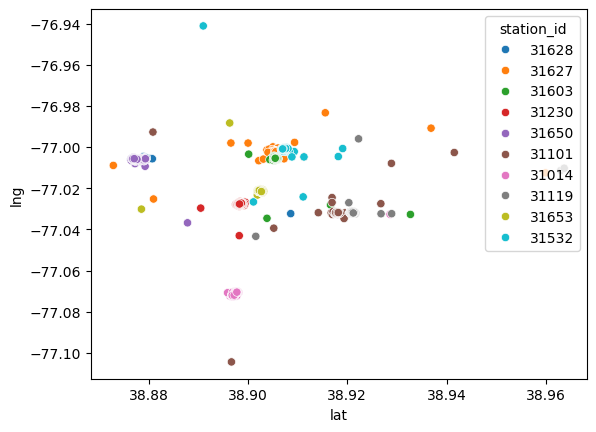

In [138]:
# scatter plot
sns.scatterplot(stations_samples, x='lat', y='lng', hue=stations_samples.station_id.astype(str))

In [139]:
# plot on map


### Clustering of Station Data

In [140]:
# # TODO needs some data cleaning first!
# nr_stations = len(set(zip(stations['station_id'], stations['station_name'])))

# from sklearn.neighbors import NearestNeighbors

# # write a cython function?
# # use haversine instead, it's a good approximation
# # geodesic_m = lambda x, y:  geodesic(x, y).m

# X = np.radians(np.array(list(zip(stations.lat, stations.lng))))

# nbrs = NearestNeighbors(n_neighbors=nr_stations, metric='haversine', algorithm='ball_tree', n_jobs=-1).fit(X)
# distances, indcs = nbrs.kneighbors(X)
# distances *= EARTH_RADIUS_M

In [141]:
# stations_moved = np.apply_along_axis(lambda d: (d > 10).any(), axis=0, arr=distances)
# print(stations_moved.shape)
# stations_moved.sum()

### Remove Outliers

In [142]:
# test data for functions below
# ids = np.random.choice(stations.station_id.unique(), size=10, replace=False)
# stations_test_set = stations[stations.station_id.apply(lambda id: id in ids)]

In [143]:
from scipy.spatial.distance import cdist
from sklearn.neighbors import LocalOutlierFactor
import math

def dist_haversine(u, v):
    # Differences in coordinates
    dlat = v[0] - u[0]
    dlon = v[1] - u[1]

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(u[0]) * math.cos(v[0]) * math.sin(dlon / 2)**2
    return 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

def remove_outliers_lof(group, lat_lng_std_tol=1-6, dist_tol=1):
    # data prep
    v = np.array(group[['lat', 'lng']]).astype(np.float32)
    # lat_mean, lat_std = np.mean(group[['lat']]), np.std(group[['lat']])
    # lng_mean, lng_std = np.mean(group[['lng']]), np.std(group[['lng']])
    # if (lat_std<tol) & (lng_std<tol):
    #     return group
    if len(v) < 5:
        return group
    v = np.radians(v)
    u = v
    # calc distances
    distances = cdist(u, v, metric=dist_haversine)
    # apply dist tolerance
    distances[distances * EARTH_RADIUS_M < dist_tol] = 0.
    # find outliers
    lof = LocalOutlierFactor(metric='precomputed', n_jobs=-1)
    pred = lof.fit_predict(distances)
    # mark outliers
    return group.iloc[np.where(pred>0)]

In [144]:
# try:
#     stations_wo_outliers = pd.DataFrame()
#     stations_wo_outliers = pd.read_parquet(config['processed_data_paths']['stations_wo_outliers'])
# except:
#     stations_wo_outliers = stations.groupby(['station_id', 'station_name']).apply(
#         remove_outliers_lof, lat_lng_std_tol=1e-4, dist_tol=1)

In [145]:
stations_calc[['station_id']].value_counts()

station_id
31117         1328
31419          835
31031          786
32019          747
31945          623
              ... 
31389            1
31947            1
32261            1
31220            1
32909            1
Name: count, Length: 257, dtype: int64

In [146]:
pd.DataFrame(stations_calc.groupby(['station_id', 'station_name']))

,0,1
0,"(31004, Aurora Hills Cmty Ctr / 18th St & S Ha...",statio...
1,"(31026, Washington Blvd & 10th St N)",station_name station_i...
2,"(31031, 15th St & N Scott St)",station_name station_id ...
3,"(31032, Washington Blvd & 7th St N)",station_name station_id...
4,"(31045, Commerce St & Fayette St)",station_name station_id ...
...,...,...
257,"(32601, Eden Center)",station_name station_id lat ...
258,"(32605, W Broad St & Little Falls St)",station_name station_...
259,"(32900, Motivate BX Tech office)",station_name station_id ...
260,"(32906, V1 Warehouse Test Station)",station_name station_id ...


In [147]:
stations_wo_outliers = stations_calc.groupby(['station_id', 'station_name']).apply(
    remove_outliers_lof, 
    lat_lng_std_tol=1e-4, 
    dist_tol=1
    )

c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\sklearn\neighbors\_lof.py:282: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\sklearn\neighbors\_lof.py:282: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\sklearn\neighbors\_lof.py:282: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\sklearn\neighbors\_lof.py:282: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  w

In [148]:
print(stations_calc.shape)
print(stations_wo_outliers.shape)

(39189, 7)
(36585, 7)


In [149]:
stations_wo_outliers.describe()

,station_id,lat,lng,date_count
count,36585.0,36585.0,36585.0,36585.000000
mean,31705.254093,38.922962,-77.053095,24.604592
std,417.185437,0.063791,0.08257,555.599198
min,31004.0,38.798691,-77.368118,1.000000
25%,31405.0,38.877411,-77.093536,1.000000
50%,31717.0,38.92342,-77.03347,2.000000
75%,32038.0,38.965721,-76.994698,4.000000
max,32909.0,39.123539,-76.825508,52481.000000


In [150]:
stations.describe()

,station_id,lat,lng,date_count
count,409604.0,409604.0,409604.0,409604.000000
mean,31417.236697,38.903821,-77.039593,47.998538
std,337.121999,0.035425,0.046289,1691.254194
min,30200.0,38.782539,-77.382591,1.000000
25%,31209.0,38.890121,-77.050583,1.000000
50%,31287.0,38.902168,-77.032318,2.000000
75%,31628.0,38.91552,-77.01532,4.000000
max,33200.0,39.125912,-76.825508,190406.000000


In [151]:
# TODO stations_wo_outliers has station_id, station_name in index and in columns - fix this
stations_wo_outliers = stations_wo_outliers.reset_index(drop=True)

### Aggregate

In [152]:
stations_agg = stations_wo_outliers.groupby(['station_id', 'station_name']).agg({
    'date_min' : 'min',
    'date_max' : 'max',
    'lat' : ['median', 'mean', 'std', 'max', 'min'],
    'lng' : ['median', 'mean', 'std', 'max', 'min']
})
stations_agg.columns = ['_'.join(col) for col in stations_agg.columns]
stations_agg = stations_agg.reset_index()
stations_agg = stations_agg.rename(columns={'date_min_min':'start_service', 'date_max_max':'end_service'})
stations_agg

,station_id,station_name,start_service,end_service,lat_median,lat_mean,lat_std,lat_max,lat_min,lng_median,lng_mean,lng_std,lng_max,lng_min
0,31004,Aurora Hills Cmty Ctr / 18th St & S Hayes St,2021-01-02,2023-12-31,38.857868,38.857876,0.000045,38.85799,38.857769,-77.059479,-77.059486,0.000048,-77.059349,-77.059578
1,31026,Washington Blvd & 10th St N,2021-01-02,2023-12-31,38.884708,38.884712,0.000064,38.884949,38.884571,-77.093498,-77.093513,0.000091,-77.0933,-77.093788
2,31031,15th St & N Scott St,2021-01-01,2023-12-31,38.890541,38.890556,0.000099,38.890869,38.89032,-77.08091,-77.080902,0.000114,-77.080643,-77.08123
3,31032,Washington Blvd & 7th St N,2021-01-02,2023-12-31,38.880798,38.880806,0.000035,38.88089,38.88073,-77.090752,-77.090759,0.000052,-77.090652,-77.090858
4,31045,Commerce St & Fayette St,2021-01-01,2023-12-31,38.805649,38.805649,0.000036,38.805729,38.805569,-77.05294,-77.05294,0.000054,-77.052818,-77.053062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,32601,Eden Center,2022-06-15,2023-12-30,38.873749,38.873749,0.000028,38.87381,38.873699,-77.152901,-77.152893,0.000037,-77.152809,-77.152969
258,32605,W Broad St & Little Falls St,2021-01-02,2023-12-31,38.883572,38.883575,0.000062,38.883739,38.88343,-77.173424,-77.173424,0.000075,-77.173241,-77.173576
259,32900,Motivate BX Tech office,2023-04-07,2023-04-07,38.964409,38.964409,<NA>,38.964409,38.964409,-77.010757,-77.010757,<NA>,-77.010757,-77.010757
260,32906,V1 Warehouse Test Station,2022-03-03,2022-03-03,38.963631,38.963631,<NA>,38.963631,38.963631,-77.010239,-77.010239,<NA>,-77.010239,-77.010239


In [153]:
# stations_agg = stations_wo_outliers.groupby(['station_id', 'station_name']).agg({
#     'date_min' : 'min',
#     'date_max' : 'max',
#     'lat' : ['mean', 'std', 'max', 'min'],
#     'lng' : ['mean', 'std', 'max', 'min']
# })

# stations_agg


### Analyse station table

In [154]:
stations_agg.describe()

,station_id,lat_median,lat_mean,lat_std,lat_max,lat_min,lng_median,lng_mean,lng_std,lng_max,lng_min
count,262.0,262.0,262.0,249.0,262.0,262.0,262.0,262.0,249.0,262.0,262.0
mean,31858.064885,38.924647,38.924703,0.000215,38.92519,38.924544,-77.091483,-77.091345,0.000477,-77.090253,-77.091615
std,410.902296,0.076497,0.076446,0.002609,0.076384,0.076493,0.120492,0.120269,0.006563,0.119886,0.120515
min,31004.0,38.79874,38.798737,0.000013,38.798779,38.798691,-77.367989,-77.367989,0.000005,-77.367859,-77.368118
25%,31535.0,38.866865,38.866857,0.000034,38.867715,38.866736,-77.165731,-77.165724,0.00004,-77.164068,-77.165859
50%,31959.0,38.91395,38.913942,0.000041,38.916145,38.913719,-77.076679,-77.076683,0.000049,-77.076035,-77.076797
75%,32204.0,38.968387,38.968389,0.000051,38.968524,38.968261,-76.992737,-76.992735,0.000061,-76.992672,-76.99279
max,32909.0,39.123459,39.123463,0.041215,39.123539,39.12339,-76.825592,-76.825592,0.10361,-76.825508,-76.825661


In [155]:
# Where does the lat, lng differ strongly?
# stations_agg[(stations_agg[('lat','std')]>1e-3) | (stations_agg[('lng','std')]>1e-3)].sort_values(by=('lat','std'), ascending=False)
stations_agg[(stations_agg[('lat_std')]>1e-3) | (stations_agg[('lng_std')]>1e-3)].sort_values(by=('lat_std'), ascending=False)

,station_id,station_name,start_service,end_service,lat_median,lat_mean,lat_std,lat_max,lat_min,lng_median,lng_mean,lng_std,lng_max,lng_min
235,32278,Blenheim Blvd & North St,2023-11-03,2023-12-30,38.847031,38.861588,0.041215,38.963589,38.84697,-77.303284,-77.266663,0.10361,-77.010239,-77.303352
205,32228,Reston Station Blvd & Sunset Hills Rd,2023-09-14,2023-12-29,38.946751,38.946636,0.000498,38.946812,38.94471,-77.3311,-77.33136,0.001047,-77.331009,-77.335419


In [156]:
# calculate diagonals of station bounding boxes
# stations bounding box:
def geodesic_m(lat1, lng1, lat2, lng2):
    return [geodesic(gPoint(x1, y1),gPoint(x2, y2)).m for x1, y1, x2, y2 in zip(lat1, lng1, lat2, lng2)]

# stations_agg['diagonal_bbox'] = geodesic_m(stations_agg[('lat', 'min')], stations_agg[('lng', 'min')], stations_agg[('lat', 'max')], stations_agg[('lng', 'max')])
stations_agg['diagonal_bbox'] = geodesic_m(stations_agg[('lat_min')], stations_agg[('lng_min')], stations_agg[('lat_max')], stations_agg[('lng_max')])
stations_agg.sort_values(by='diagonal_bbox', ascending=False)

,station_id,station_name,start_service,end_service,lat_median,lat_mean,lat_std,lat_max,lat_min,lng_median,lng_mean,lng_std,lng_max,lng_min,diagonal_bbox
235,32278,Blenheim Blvd & North St,2023-11-03,2023-12-30,38.847031,38.861588,0.041215,38.963589,38.84697,-77.303284,-77.266663,0.10361,-77.010239,-77.303352,28531.508544
205,32228,Reston Station Blvd & Sunset Hills Rd,2023-09-14,2023-12-29,38.946751,38.946636,0.000498,38.946812,38.94471,-77.3311,-77.33136,0.001047,-77.331009,-77.335419,447.881770
51,31413,3rd & Underwood St NW,2021-01-01,2023-12-31,38.96891,38.96925,0.000515,38.969978,38.968731,-77.016289,-77.016335,0.000129,-77.016159,-77.016617,144.051101
135,31971,S Wayne and 9th St,2023-10-19,2023-10-19,38.864605,38.864605,0.000119,38.864689,38.864521,-77.083061,-77.083061,0.00082,-77.082481,-77.083641,102.359286
146,32013,Montgomery & East Ln,2021-01-01,2023-03-18,38.983509,38.983494,0.000104,38.983761,38.9832,-77.095337,-77.095345,0.000173,-77.09494,-77.095818,98.258674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,31386,Prosperity Ave & Avenir Pl,2023-12-22,2023-12-31,38.881439,38.881439,<NA>,38.881439,38.881439,-77.230377,-77.230377,<NA>,-77.230377,-77.230377,0.000000
236,32279,George Mason Blvd & Armstrong,2023-11-01,2023-11-01,38.841099,38.841099,<NA>,38.841099,38.841099,-77.307182,-77.307182,<NA>,-77.307182,-77.307182,0.000000
259,32900,Motivate BX Tech office,2023-04-07,2023-04-07,38.964409,38.964409,<NA>,38.964409,38.964409,-77.010757,-77.010757,<NA>,-77.010757,-77.010757,0.000000
260,32906,V1 Warehouse Test Station,2022-03-03,2022-03-03,38.963631,38.963631,<NA>,38.963631,38.963631,-77.010239,-77.010239,<NA>,-77.010239,-77.010239,0.000000


* bounding boxes are up to 20km large!
* there are large outliers in the feckin data

### Build stations table

In [157]:
stations_docked_bikes.columns

Index(['station_name', 'station_id', 'lat_median', 'lat_mean', 'lat_std',
       'lat_count', 'lng_median', 'lng_mean', 'lng_std', 'lng_count',
       'date_min', 'date_max'],
      dtype='object')

In [158]:
stations_agg.columns

Index(['station_id', 'station_name', 'start_service', 'end_service',
       'lat_median', 'lat_mean', 'lat_std', 'lat_max', 'lat_min', 'lng_median',
       'lng_mean', 'lng_std', 'lng_max', 'lng_min', 'diagonal_bbox'],
      dtype='object')

In [159]:
stations_docked_bikes.shape

(816, 12)

In [160]:
stations_agg.shape

(262, 15)

In [161]:
station_cols = ['station_name', 'station_id', 'lat_median','lng_median']
stations = pd.concat([stations_docked_bikes[station_cols], stations_agg[station_cols]], axis=0)
stations

,station_name,station_id,lat_median,lng_median
0,10th & E St NW,31256,38.895908,-77.026062
1,10th & Florida Ave NW,31120,38.920391,-77.025681
2,10th & G St NW,31274,38.898239,-77.026237
3,10th & H St NE,31672,38.899979,-76.992722
4,10th & K St NW,31263,38.902401,-77.026222
...,...,...,...,...
257,Eden Center,32601,38.873749,-77.152901
258,W Broad St & Little Falls St,32605,38.883572,-77.173424
259,Motivate BX Tech office,32900,38.964409,-77.010757
260,V1 Warehouse Test Station,32906,38.963631,-77.010239


In [162]:
stations_redo_1 = stations[stations.duplicated(['station_name', 'station_id'], keep='first')].set_index(['station_id', 'station_name'])
stations_redo_2 = stations[stations.duplicated(['station_name', 'station_id'], keep='last')].set_index(['station_id', 'station_name'])

diff = pd.DataFrame(data=[
    abs(stations_redo_1.lat_median - stations_redo_2.lat_median),
    abs(stations_redo_1.lng_median - stations_redo_2.lng_median) 
]).T

TOL = 1e-3
diff[(diff.lat_median>TOL) | (diff.lng_median>TOL)]

,,lat_median,lng_median
station_id,station_name,,


In [171]:
stations = stations.drop_duplicates(subset=['station_id', 'station_name'], keep='first')

In [172]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 867 entries, 0 to 1074
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   station_name           867 non-null    object         
 1   station_id             867 non-null    uint32[pyarrow]
 2   lat_median             867 non-null    float[pyarrow] 
 3   lng_median             867 non-null    float[pyarrow] 
 4   total_count_start_end  867 non-null    int64          
 5   date_start             867 non-null    object         
 6   date_end               867 non-null    object         
dtypes: float[pyarrow](2), int64(1), object(3), uint32[pyarrow](1)
memory usage: 44.0+ KB


In [174]:
stations_ = stations.copy()

### Merge Meta Data: Count, Service Dates

- Count: How often was the feckin station targeted in the whole period?
- Service Dates: When was the first and last service date?

In [175]:
# get all station data
start_stations = get_station_data(df, mask_start, ['ended_at', 'start_station_name', 'start_station_id'], dec=NDEC_LAT_LNG, drop_dups=False)
end_stations = get_station_data(df, mask_end, ['ended_at', 'end_station_name','end_station_id'], dec=NDEC_LAT_LNG, drop_dups=False)
stations_service_dates = pd.concat(
    [start_stations, end_stations],
    axis = 0
    )

# group by 
stations_service_dates = stations_service_dates.groupby(['station_name', 'station_id']).agg({'date':['count', 'min', 'max']})
stations_service_dates.columns = ['_'.join(col) for col in stations_service_dates.columns]
stations_service_dates = stations_service_dates.rename(columns={'date_count':'total_count_start_end'})
stations_service_dates = stations_service_dates.rename(columns={'date_min' : 'date_start', 'date_max' : 'date_end'})
stations_service_dates = stations_service_dates.reset_index()


In [176]:
stations_service_dates.shape

(867, 5)

In [177]:
# stations_service_dates.loc[stations_service_dates.date_end>=pd.Timestamp('2023.12.31').date(), 'date_end'] = np.nan
stations_service_dates.sort_values(by='total_count_start_end', ascending=False)

,station_name,station_id,total_count_start_end,date_start,date_end
602,New Hampshire Ave & T St NW,31229,206524,2021-01-01,2023-12-31
323,Columbus Circle / Union Station,31623,206101,2021-01-01,2023-12-31
74,15th & P St NW,31201,195432,2021-01-01,2023-12-31
514,Lincoln Memorial,31258,192109,2021-01-01,2023-12-31
459,Jefferson Dr & 14th St SW,31247,179895,2021-01-01,2024-01-01
...,...,...,...,...,...
7,10th & Rhode Island Ave NE,31535,2,2022-08-18,2022-08-18
417,George Mason Blvd & Armstrong,32279,1,2023-11-01,2023-11-01
566,Motivate BX Tech office,32900,1,2023-04-07,2023-04-07
492,Kingsbridge Dr & Draper Dr,31387,1,2023-12-30,2023-12-30


In [181]:
stations = pd.merge(stations, stations_service_dates, on=['station_id', 'station_name'], how='left')
stations

,station_name,station_id,lat_median,lng_median,total_count_start_end,date_start,date_end
0,10th & E St NW,31256,38.895908,-77.026062,66692,2021-01-01,2023-12-31
1,10th & Florida Ave NW,31120,38.920391,-77.025681,39181,2021-01-01,2022-08-18
2,10th & G St NW,31274,38.898239,-77.026237,52073,2021-01-01,2024-01-01
3,10th & H St NE,31672,38.899979,-76.992722,33491,2021-11-30,2023-12-31
4,10th & K St NW,31263,38.902401,-77.026222,78888,2021-01-01,2023-12-31
...,...,...,...,...,...,...,...
862,School St & George Mason Blvd,32282,38.837379,-77.309402,30,2023-11-08,2023-12-30
863,South St & University Dr,32283,38.844269,-77.305351,12,2023-11-11,2023-12-30
864,Motivate BX Tech office,32900,38.964409,-77.010757,1,2023-04-07,2023-04-07
865,V1 Warehouse Test Station,32906,38.963631,-77.010239,8,2022-03-03,2022-03-03


## Bike Types

### Docked Bikes

In [70]:
docked_bikes = df.loc[df.rideable_type == 'docked_bike']
print(docked_bikes.shape)
docked_bikes.head()

(532975, 17)


,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_is_within_city,end_is_within_city,ride_is_within_city,is_holiday,ride_duration
8,docked_bike,2021-01-01 00:21:19,2021-01-01 00:33:31,15th & F St NE,31632,1st & M St SE,31650,38.897202,-76.983582,38.876888,-77.006073,casual,True,True,True,True,732
18,docked_bike,2021-01-01 00:26:51,2021-01-01 00:47:48,Henry Bacon Dr & Lincoln Memorial Circle NW,31289,14th St & New York Ave NW,31216,38.890541,-77.049377,38.899632,-77.031693,casual,True,True,True,True,1257
35,docked_bike,2021-01-01 00:47:55,2021-01-01 03:04:53,12th & L St NW,31251,7th & K St NW,31653,38.90382,-77.028397,38.902672,-77.021393,casual,True,True,True,True,8218
44,docked_bike,2021-01-01 00:59:41,2021-01-01 01:27:52,Thomas Circle,31241,Thomas Circle,31241,38.905899,-77.032501,38.905899,-77.032501,casual,True,True,True,True,1691
45,docked_bike,2021-01-01 00:59:44,2021-01-01 01:27:55,Thomas Circle,31241,Thomas Circle,31241,38.905899,-77.032501,38.905899,-77.032501,casual,True,True,True,True,1691


In [71]:
docked_bikes.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,ride_duration
count,532975,532975,532975.0,532975.0,532975.0,532975.0,532975.0,532975.0,532975.000000
mean,2022-04-30 01:59:12.882000,2022-04-30 03:13:32.728000,31348.436232,31350.454492,38.893117,-77.038619,38.892816,-77.037745,3210.148446
min,2021-01-01 00:21:19,2021-01-01 00:33:31,30200.0,30200.0,38.782631,-77.368423,38.782631,-77.368423,30.000000
25%,2021-08-25 21:25:56.500000,2021-08-25 23:07:17,31233.0,31232.0,38.887379,-77.049377,38.88731,-77.049377,1071.000000
50%,2022-05-20 09:59:39,2022-05-20 10:46:54,31258.0,31258.0,38.89061,-77.033379,38.892239,-77.033234,1871.000000
75%,2022-10-21 16:06:02,2022-10-21 16:51:22.500000,31314.0,31321.0,38.902061,-77.023048,38.902061,-77.02224,3487.000000
max,2023-09-13 11:27:51,2023-10-02 08:19:46,33200.0,33200.0,39.125832,-76.825539,39.125832,-76.825539,86396.000000
std,NaN,NaN,274.537532,276.241926,0.027976,0.037553,0.027745,0.037425,5713.588127


In [72]:
print(docked_bikes.start_station_id.isna().sum())
print(docked_bikes.end_station_id.isna().sum())

0
0


In [73]:
df.rideable_type.value_counts()

rideable_type
classic_bike     7638352
electric_bike    2402463
docked_bike       532975
Name: count, dtype: int64

docked_bikes can only be ridden from station to station -> classic bikes

In [74]:
df[df.rideable_type == 'docked_bikes'].rideable_type = 'classic_bike'

### E-Bikes

In [75]:
df_electric_bikes = df.loc[df.rideable_type == 'electric_bike']
df_electric_bikes.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,ride_duration
count,2402463,2402463,1679920.0,1645906.0,2402463.0,2402463.0,2402463.0,2402463.0,2.402463e+06
mean,2022-12-03 12:52:34.476000,2022-12-03 13:07:55.712000,31381.665942,31381.975443,38.909709,-77.031154,38.909386,-77.031108,9.474536e+02
min,2021-01-01 00:13:43,2021-01-01 00:28:45,30200.0,30200.0,38.759998,-77.400002,38.709999,-77.449997,3.000000e+01
25%,2022-03-22 12:16:58,2022-03-22 12:29:21,31201.0,31201.0,38.89706,-77.04425,38.896919,-77.044403,3.730000e+02
50%,2023-04-17 23:11:17,2023-04-17 23:24:21,31293.0,31293.0,38.908829,-77.029999,38.908642,-77.029999,6.420000e+02
75%,2023-09-07 19:50:43.500000,2023-09-07 20:02:24.500000,31605.0,31606.0,38.92342,-77.010002,38.922852,-77.010002,1.078000e+03
max,2023-12-31 23:59:38,2024-01-01 01:15:48,33200.0,33200.0,39.139999,-76.82,39.16,-76.800003,8.639900e+04
std,NaN,NaN,283.853709,283.762732,0.029983,0.036097,0.030147,0.036402,1.853216e+03


In [76]:
print(df_electric_bikes.start_station_id.isna().sum(), df_electric_bikes.shape[0])

722543 2402463


# Preprocess Data

## Create Graph Data

# Export

In [182]:
%store df stations

Stored 'df' (DataFrame)
Stored 'stations' (DataFrame)


In [183]:
df.to_parquet(config['processed_data_paths']['rides'])
stations.to_parquet(config['processed_data_paths']['stations'])

# Conclusions from Data Cleaning

- Bike location measurements has to be improved: They spread far around a station.
- 